In [117]:
################################################################################
# SETUP
################################################################################

# Convenience and saving flags
ABRIDGED_RUN = False # Set to True to train and validate on less epochs, for quick funcitonality tests etc
SAVE_AFTER_TRAINING = True # Save the model when you are done
SAVE_CHECKPOINTS = True # Save the model after every epoch
REPORT_TRAINING_LOSS_PER_EPOCH = True # Track the training loss each epoch, and write it to a file after training
REPORT_VALIDATION_LOSS_PER_EPOCH = True # Lets us make a nice learning curve after training

# Training hyperparameters
NUM_EPOCHS = 40000 # Number of epochs to train our network
if ABRIDGED_RUN == True:
    NUM_EPOCHS = 1001
NN_WIDTH = 128

LEARNING_RATE = 1e-5 # Learning rate for our optimizer

# Directories
CHECKPOINT_DIR = "checkpoints/" # Checkpoints, models, and training data will be saved here
MODEL_NAME = None

In [118]:
################################################################################
# IMPORTS
################################################################################

print("Importing modules")

# Basic imports
import pandas as pd
import numpy as np
np.random.seed(1234)
import time
import scipy.io
from scipy.stats import qmc
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split
from pathlib import Path

# Torch imports
import torch
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
torch.set_default_dtype(torch.float)
torch.manual_seed(1234)
print("Import complete")


device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"{device} enabled")

Importing modules
Import complete
mps enabled


## Test Case for PINN: 2D Poisson

We consider the equation $$u_{xx} + u_{yy} = f$$
where $$f(x, y) = -8\pi^2 \sin(2\pi x) \sin(2\pi y), \; (x,y) \in \Omega, \quad \Omega = [0,1] \times [0,1].$$

We impose the following boundary conditions.
1. Homogeneous Dirichlet BC on the bottom: $$u(x, 0) = 0, \; x \in [0,1].$$
2. Periodic BC on the sides: $$u(0, y) = u(1, y), \; y \in [0,1]$$
3. Neumann BC on the top: $$\frac{\partial u}{\partial n}(x, 1) = 2\pi \sin(2\pi x), \; x \in [0,1].$$

Explicit solution that we are aiming to approximate: $$u(x, y) = \sin(2\pi x) \sin(2\pi y), \; (x,y) \in \Omega.$$

(-0.05, 1.05, -0.05, 1.05)

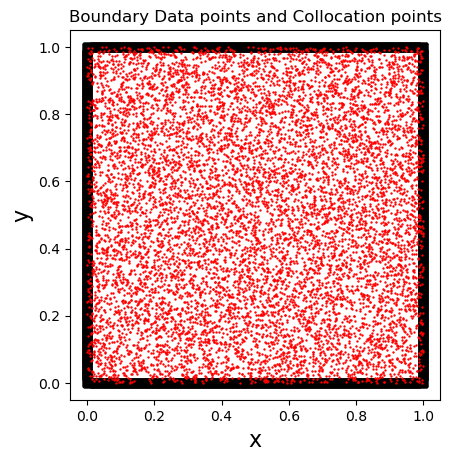

In [119]:
################################################################################
# DOMAIN INITIALIZATION
################################################################################

x_min = 0
x_max = 1
y_min = 0
y_max = 1

total_points_x = 1000
total_points_y = 1000

N_boundary = 4 # number of boundaries
N_u_boundary = 2500 # number of points on each boundary
N_u = N_boundary * N_u_boundary
N_f = 10000 # number of collocation points

#Boundary condition weights in loss function 
w_bc_top = 1
w_bc_bottom = 4
w_bc_lr = 1

engine = qmc.LatinHypercube(d=1)

boundary_top = engine.random(n = N_u_boundary)
boundary_lr = engine.random(n = N_u_boundary)
boundary_bot = engine.random(n = N_u_boundary)

data = np.zeros([N_boundary, N_u_boundary, 2])

data[0, :, 0] = boundary_top[:, 0]
data[1, :, 1] = boundary_lr[:, 0]
data[2, :, 1] = boundary_lr[:, 0]
data[3, :, 0] = boundary_bot[:, 0]

data[0, :, 1] = np.ones(N_u_boundary) # y = 1
data[1, :, 0] = np.zeros(N_u_boundary) # x = 0
data[2, :, 0] = np.ones(N_u_boundary) # x = 1
data[3, :, 1] = np.zeros(N_u_boundary) # y = 0

data = data.reshape(-1, 2)
x_d, y_d = data[:, 0:1], data[:, 1:2]

engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n = N_f)

x_f, y_f = colloc[:, 0:1], colloc[:, 1:2]

plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=2., marker=".", c="r", label="CP")
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.axis("square")
#plt.show()


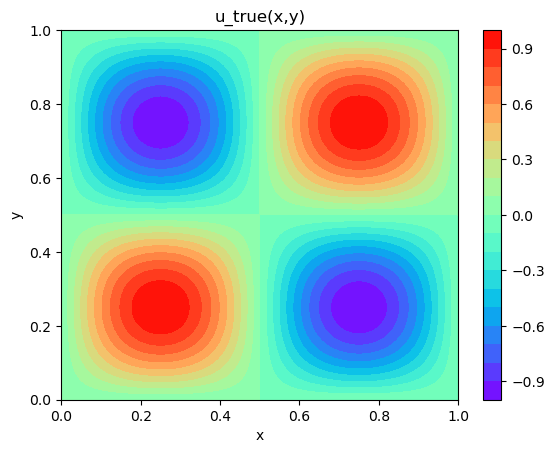

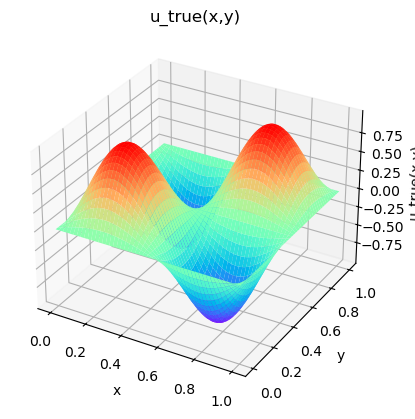

In [120]:
#Plotting explicit solution
def u_sol(x, y):
    return torch.sin(2 * np.pi * x) * torch.sin(2 * np.pi * y)

x = torch.linspace(x_min, x_max, total_points_x)
y = torch.linspace(y_min, y_max, total_points_y)

X, Y = torch.meshgrid(x, y)
U_sol = u_sol(X, Y)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, U_sol ,20,cmap="rainbow")
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('u_true(x,y)')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()


ax = plt.axes(projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), U_sol.numpy(),cmap="rainbow")
ax.set_title('u_true(x,y)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u_true(x,y)')
plt.show()

In [121]:
class PINN(nn.Module):

    def __init__(self):
        super().__init__()
        
        #self.activation = nn.Tanh()
        
        self.loss_function = nn.MSELoss(reduction='mean')
        
        self.u = nn.Sequential(
            nn.Linear(2, NN_WIDTH),
            nn.Tanh(),
            nn.Linear(NN_WIDTH, NN_WIDTH),
            nn.Tanh(),
            nn.Linear(NN_WIDTH, NN_WIDTH),
            nn.Tanh(),
            nn.Linear(NN_WIDTH, NN_WIDTH),
            nn.Tanh(),
            nn.Linear(NN_WIDTH, NN_WIDTH),
            nn.Tanh(),
            nn.Linear(NN_WIDTH, NN_WIDTH),
            nn.Tanh(),
            nn.Linear(NN_WIDTH, NN_WIDTH),
            nn.Tanh(),
            nn.Linear(NN_WIDTH, NN_WIDTH),
            nn.Tanh(),
            nn.Dropout(p=0.05),
            nn.Linear(NN_WIDTH, NN_WIDTH),
            nn.Tanh(),
            nn.Dropout(p=0.05),
            nn.Linear(NN_WIDTH, NN_WIDTH),
            nn.Tanh(),
            nn.Dropout(p=0.05),
            nn.Linear(NN_WIDTH, 1) 
            )
       
        # Xavier initialization
        for layer in self.u:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight) 
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
    
    def forward(self, x, y):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)

        if not torch.is_tensor(y):
            y = torch.from_numpy(y)
        
        a = torch.cat((x.float(), y.float()), axis=1)
        
        u = self.u(a)
        
        return u
    
    # Neumann BC on top
    def loss_BC_top(self, x):
        x_clone = x.clone().requires_grad_(True)
        y = torch.ones_like(x_clone).requires_grad_(True)
        
        u = self.forward(x_clone, y)
        u_y = autograd.grad(u.sum(), y, create_graph=True)[0]
        
        return self.loss_function(u_y, 2 * np.pi * torch.sin(2 * np.pi * x_clone))
    
    # Periodic BC on left/right
    def loss_BC_lr(self, y):
        u_l = self.forward(torch.zeros_like(y), y)
        u_r = self.forward(torch.ones_like(y), y)
        
        return self.loss_function(u_l, u_r)
    
    # Dirichlet BC on bottom
    def loss_BC_bot(self, x):
        return self.loss_function(self.forward(x, torch.zeros_like(x)), torch.zeros_like(x))
    
    def loss_PDE(self, x, y):
        x_clone = x.clone().requires_grad_(True)
        y_clone = y.clone().requires_grad_(True)
        
        u = self.forward(x_clone, y_clone)
        u_x = autograd.grad(u.sum(), x_clone, create_graph=True)[0]
        u_y = autograd.grad(u.sum(), y_clone, create_graph=True)[0]
        u_xx = autograd.grad(u_x.sum(), x_clone, create_graph=True)[0]
        u_yy = autograd.grad(u_y.sum(), y_clone, create_graph=True)[0]

        f = u_xx + u_yy
        return self.loss_function(f + 8 * np.pi**2 * torch.sin(2 * np.pi * x_clone) * torch.sin(2 * np.pi * y_clone), torch.zeros_like(f))
    
    def loss (self, x_top, x_bot, y_lr, x_PDE, y_PDE):
        return w_bc_bottom * self.loss_BC_bot(x_bot) + w_bc_lr * self.loss_BC_lr(y_lr) + w_bc_top * self.loss_BC_top(x_top) + self.loss_PDE(x_PDE, y_PDE)

In [122]:
x_test = torch.hstack((X.transpose(1, 0).flatten()[:, None], Y.transpose(1, 0).flatten()[:, None]))
u_test = U_sol.transpose(1, 0).flatten()[:, None]

x_test = x_test.float().to(device)
u_test = u_test.float().to(device)

train_bd_top = torch.tensor(boundary_top).float().to(device)
train_bd_lr = torch.tensor(boundary_lr).float().to(device)
train_bd_bot = torch.tensor(boundary_bot).float().to(device)

x_train_colloc = torch.tensor(x_f).float().to(device)
y_train_colloc = torch.tensor(y_f).float().to(device)

In [123]:
################################################################################
# TRAINING SETUP
################################################################################

# Create a saving directory if needed
output_dir = Path(f'{CHECKPOINT_DIR}{MODEL_NAME}')
output_dir.mkdir(parents=True, exist_ok=True)
output_dir = f'{CHECKPOINT_DIR}{MODEL_NAME}'

# Instantiate our model
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

summary(model)

Layer (type:depth-idx)                   Param #
PINN                                     --
├─MSELoss: 1-1                           --
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       384
│    └─Tanh: 2-2                         --
│    └─Linear: 2-3                       16,512
│    └─Tanh: 2-4                         --
│    └─Linear: 2-5                       16,512
│    └─Tanh: 2-6                         --
│    └─Linear: 2-7                       16,512
│    └─Tanh: 2-8                         --
│    └─Linear: 2-9                       16,512
│    └─Tanh: 2-10                        --
│    └─Linear: 2-11                      16,512
│    └─Tanh: 2-12                        --
│    └─Linear: 2-13                      16,512
│    └─Tanh: 2-14                        --
│    └─Linear: 2-15                      16,512
│    └─Tanh: 2-16                        --
│    └─Dropout: 2-17                     --
│    └─Linear: 2-18                      1

In [124]:
start_time = time.time()

training_losses = np.array([])
validation_losses = np.array([])

#Turn on the gradient

torch.enable_grad() 

for epoch in tqdm(range(NUM_EPOCHS), leave = False):
    
    optimizer.zero_grad()
    loss = model.loss(train_bd_top, train_bd_bot, train_bd_lr, x_train_colloc, y_train_colloc)
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        # Save checkpoint
        if SAVE_CHECKPOINTS == True:
            torch.save(model.state_dict(), f"{CHECKPOINT_DIR}{MODEL_NAME}/checkpoint_{epoch}.pt")

        # Compute training loss
        if REPORT_TRAINING_LOSS_PER_EPOCH == True:    
            training_losses = np.append(training_losses, loss.item())
        
        if REPORT_VALIDATION_LOSS_PER_EPOCH == True:
            model.eval()
            torch.no_grad()
            validation_loss = model.loss_function(model(x_test[:, 0:1], x_test[:, 1:2]), u_sol(x_test[:, 0:1], x_test[:, 1:2]))
            validation_losses = np.append(validation_losses, validation_loss.cpu().item())
            model.train()
            torch.enable_grad()
        
        #if epoch % 1000 == 0:
        
        print(f'Epoch {epoch}, Training loss {loss.item()}, Validation loss {validation_loss.item()}')
        
        losses = pd.DataFrame({"training_losses":training_losses, "validation_losses":validation_losses})
        cols = []
        
        if REPORT_TRAINING_LOSS_PER_EPOCH == True:
            cols += ["training_losses"]
            
        if REPORT_VALIDATION_LOSS_PER_EPOCH == True:
            cols += ["validation_losses"]
            
        if len(cols) > 0:
            losses[cols].to_csv(f'{output_dir}/losses.csv', index = False)
        
end_time = time.time()

print('Finished Training')

print(f'Training time: {end_time - start_time}s')

  0%|          | 2/40000 [00:01<6:49:36,  1.63it/s] 

Epoch 0, Training loss 1575.646484375, Validation loss 0.2573571503162384


  3%|▎         | 1002/40000 [00:55<2:27:35,  4.40it/s]

Epoch 1000, Training loss 1399.1298828125, Validation loss 1.5321147441864014


  5%|▌         | 2004/40000 [01:48<1:25:11,  7.43it/s]

Epoch 2000, Training loss 1042.5955810546875, Validation loss 2.4077870845794678


  8%|▊         | 3002/40000 [02:44<3:20:01,  3.08it/s]

Epoch 3000, Training loss 981.9930419921875, Validation loss 1.949431300163269


 10%|█         | 4002/40000 [03:40<3:45:44,  2.66it/s]

Epoch 4000, Training loss 922.346435546875, Validation loss 2.2392680644989014


 13%|█▎        | 5002/40000 [04:34<3:04:53,  3.15it/s]

Epoch 5000, Training loss 878.3165893554688, Validation loss 2.5164434909820557


 15%|█▌        | 6002/40000 [05:31<3:36:00,  2.62it/s]

Epoch 6000, Training loss 847.5376586914062, Validation loss 2.0613038539886475


 18%|█▊        | 7002/40000 [06:25<2:35:48,  3.53it/s]

Epoch 7000, Training loss 821.9590454101562, Validation loss 1.3134177923202515


 20%|██        | 8002/40000 [07:21<3:22:15,  2.64it/s]

Epoch 8000, Training loss 799.8294067382812, Validation loss 0.6132188439369202


 23%|██▎       | 9004/40000 [08:15<1:11:11,  7.26it/s]

Epoch 9000, Training loss 767.9601440429688, Validation loss 0.3094159960746765


 25%|██▌       | 10004/40000 [09:08<1:07:03,  7.46it/s]

Epoch 10000, Training loss 728.3712768554688, Validation loss 0.5038320422172546


 28%|██▊       | 11002/40000 [10:02<2:16:17,  3.55it/s]

Epoch 11000, Training loss 605.6377563476562, Validation loss 1.6721267700195312


 30%|███       | 12002/40000 [10:58<3:08:07,  2.48it/s]

Epoch 12000, Training loss 352.0722351074219, Validation loss 2.819197416305542


 33%|███▎      | 13004/40000 [11:52<59:44,  7.53it/s]  

Epoch 13000, Training loss 283.23675537109375, Validation loss 1.8460204601287842


 35%|███▌      | 14004/40000 [12:45<1:00:27,  7.17it/s]

Epoch 14000, Training loss 233.21885681152344, Validation loss 1.2530570030212402


 38%|███▊      | 15002/40000 [13:40<2:15:24,  3.08it/s]

Epoch 15000, Training loss 177.07272338867188, Validation loss 0.9300764799118042


 40%|████      | 16002/40000 [14:35<2:25:43,  2.74it/s]

Epoch 16000, Training loss 127.33302307128906, Validation loss 0.8058501482009888


 43%|████▎     | 17002/40000 [15:32<2:10:09,  2.94it/s]

Epoch 17000, Training loss 94.79476165771484, Validation loss 0.6938382387161255


 45%|████▌     | 18002/40000 [16:29<2:36:20,  2.35it/s]

Epoch 18000, Training loss 74.98130798339844, Validation loss 0.57539963722229


 48%|████▊     | 19002/40000 [17:24<1:57:04,  2.99it/s]

Epoch 19000, Training loss 63.08814239501953, Validation loss 0.46001213788986206


 50%|█████     | 20004/40000 [18:20<1:30:08,  3.70it/s]

Epoch 20000, Training loss 54.406715393066406, Validation loss 0.36646267771720886


 53%|█████▎    | 21002/40000 [19:15<1:41:03,  3.13it/s]

Epoch 21000, Training loss 46.986019134521484, Validation loss 0.2981713116168976


 55%|█████▌    | 22004/40000 [20:11<1:16:06,  3.94it/s]

Epoch 22000, Training loss 40.69437026977539, Validation loss 0.24240493774414062


 58%|█████▊    | 23002/40000 [21:06<1:36:04,  2.95it/s]

Epoch 23000, Training loss 37.270721435546875, Validation loss 0.1953110247850418


 60%|██████    | 24002/40000 [22:01<1:31:11,  2.92it/s]

Epoch 24000, Training loss 31.82947540283203, Validation loss 0.1561994105577469


 63%|██████▎   | 25002/40000 [22:57<1:10:03,  3.57it/s]

Epoch 25000, Training loss 28.366369247436523, Validation loss 0.12205684185028076


 65%|██████▌   | 26004/40000 [23:52<1:02:18,  3.74it/s]

Epoch 26000, Training loss 25.93299674987793, Validation loss 0.09282809495925903


 68%|██████▊   | 27004/40000 [24:46<28:41,  7.55it/s]  

Epoch 27000, Training loss 23.48724365234375, Validation loss 0.06886587291955948


 70%|███████   | 28002/40000 [25:43<1:13:15,  2.73it/s]

Epoch 28000, Training loss 21.204418182373047, Validation loss 0.048960309475660324


 73%|███████▎  | 29002/40000 [26:38<53:41,  3.41it/s]  

Epoch 29000, Training loss 20.113210678100586, Validation loss 0.034480009227991104


 75%|███████▌  | 30002/40000 [27:34<1:00:10,  2.77it/s]

Epoch 30000, Training loss 18.69021987915039, Validation loss 0.02387884259223938


 78%|███████▊  | 31004/40000 [28:28<19:41,  7.61it/s]  

Epoch 31000, Training loss 17.743127822875977, Validation loss 0.01688440702855587


 80%|████████  | 32002/40000 [29:24<49:37,  2.69it/s]

Epoch 32000, Training loss 16.302810668945312, Validation loss 0.01195492409169674


 83%|████████▎ | 33002/40000 [30:19<39:31,  2.95it/s]

Epoch 33000, Training loss 15.897247314453125, Validation loss 0.008971314877271652


 85%|████████▌ | 34004/40000 [31:14<16:26,  6.08it/s]

Epoch 34000, Training loss 14.47642993927002, Validation loss 0.00727036502212286


 88%|████████▊ | 35004/40000 [32:08<13:58,  5.96it/s]

Epoch 35000, Training loss 13.898446083068848, Validation loss 0.006426515989005566


 90%|█████████ | 36002/40000 [33:04<24:24,  2.73it/s]

Epoch 36000, Training loss 13.353070259094238, Validation loss 0.006344099063426256


 93%|█████████▎| 37004/40000 [33:58<06:50,  7.30it/s]

Epoch 37000, Training loss 12.581927299499512, Validation loss 0.0068500773049890995


 95%|█████████▌| 38004/40000 [34:51<02:20, 14.25it/s]

Epoch 38000, Training loss 11.880922317504883, Validation loss 0.0077975839376449585


 98%|█████████▊| 39002/40000 [35:46<05:02,  3.30it/s]

Epoch 39000, Training loss 11.207763671875, Validation loss 0.009279170073568821


Finished Training
Training time: 2198.971132040024s


In [125]:
################################################################################
# SAVE AND REPORT 
################################################################################

# Save model
if SAVE_AFTER_TRAINING == True:
    torch.save(model.state_dict(), f'{output_dir}/final.pt')

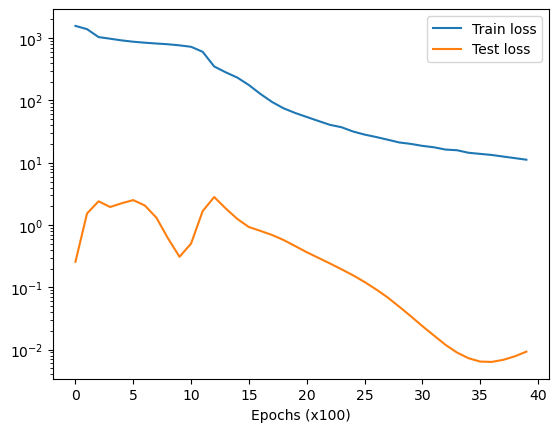

In [129]:
plt.semilogy(training_losses, label='Train loss')
plt.semilogy(validation_losses, label='Test loss')
plt.xlabel('Epochs (x100)')
plt.legend()

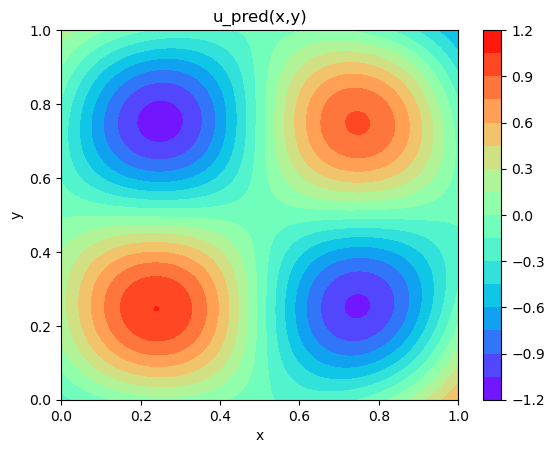

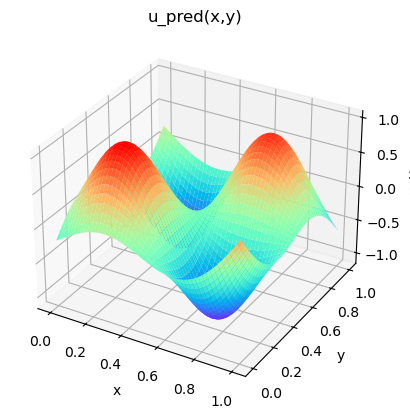

In [127]:
model.eval()
u_pred = model.forward(x_test[:, 0:1], x_test[:, 1:2]).cpu().detach()
u_pred = u_pred.reshape(total_points_x, total_points_y).transpose(1, 0)


fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, u_pred ,20,cmap="rainbow")
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('u_pred(x,y)')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()


ax = plt.axes(projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), u_pred.numpy(),cmap="rainbow")
ax.set_title('u_pred(x,y)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u_pred(x,y)')
plt.show()

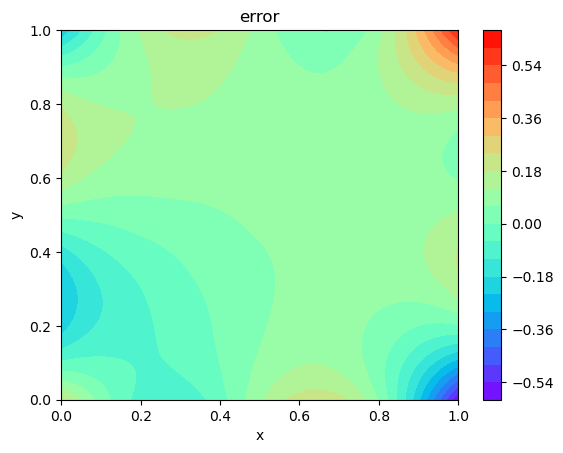

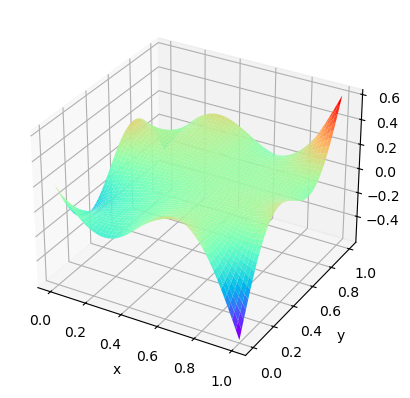

In [128]:
error = u_sol(X, Y) - u_pred

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, error ,20,cmap="rainbow")
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('error')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()


ax = plt.axes(projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), error.numpy(),cmap="rainbow")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('error')
plt.show()